# import 

In [75]:
%reset -f
import numpy as np
import json
import traceback
from matplotlib import pyplot as plt
import pandas as pd


In [76]:
pi   = np.pi
inf  = np.inf
#
exp  = lambda x: np.exp(x)
#
def norm(vec):
    if len(vec.shape)>1:
        return np.linalg.norm(vec, axis=1)
    else: return np.linalg.norm(vec)
#
vec  = lambda *args: np.array([*args])
unit = lambda *args: vec(*args)/norm(vec(*args))
span = lambda eval, evec : np.tensordot(eval, evec, axes=0)
sbs  = lambda cval: abs(cval)**2

# Class

In [77]:
class Xray:
    CuKa1  = 1.5406
    ttheta = np.linspace(0, pi, 1024)[1:]
    TTHETA = np.rad2deg(ttheta)

    def __init__(self, wavelength=CuKa1):
        self.wavelength = wavelength # Å unit
        self.k = 2 * pi / wavelength
        (h, c, e) = (6.62607015E-34, 299792458, 1.6021773349E-19)
        self.Energy = h * c / (wavelength * 1E-10) / e
        self.G = 2 * self.k * np.sin(Xray.ttheta/2)
    
    def Q(self, *ref):
        return span(self.G, unit(*ref))

In [78]:
class Atom():
	# File path
	# https://lampz.tugraz.at/~hadley/ss1/crystaldiffraction/atomicformfactors/formfactors.php
	PATH = "./DATA" 
	with open(PATH+"/AFF_F0.json", "r") as f:
		AtomicFormFactor = json.load(f)
	#
	def __init__(self, Z):
		self.Z = Z
		self.__den__ = 1
		self.f = None
		#
		(_, _, _, text) = traceback.extract_stack()[-2]
		self.def_name = text[:text.find('=')].strip()
	def __truediv__(self, num):
		atom = Atom(self.Z)
		atom.def_name = self.def_name
		atom.__den__ = num
		return atom
	def __call__(self, *args):
		return (self, *args)
	#
	def aff(self, Q, E=Xray().Energy):
		if self.f == None:
			f = pd.read_csv(Atom.PATH+f"/sf/{self.def_name.lower()}.nff", delimiter='\s+')	
			differences = abs(f.iloc[:, 0] - E)
			closest_row = f.loc[[differences.idxmin()]]
			self.f = vec(closest_row.f1 + 1j * closest_row.f2)[0]

		(a1, b1, a2, b2, a3, b3, a4, b4, c) = self.AtomicFormFactor[self.def_name]
		f0 = self.f + sum(c + vec(*[a * exp(-1 * b * np.power(norm(Q) / (4 * pi), 2)) for a, b in zip((a1, a2, a3, a4), (b1, b2, b3, b4))]))
		return f0 / self.__den__

In [79]:
class Molecule():
    def __init__(self, abc, structure):
        self.abc = vec(*abc)
        self.structure = vec(*structure)
        self.atoms = self.structure[:,0]
        self.RJ = self.structure[:,1:] * self.abc
    def __truediv__(self, substrate):
        return Molecule(
            abc = substrate.const_volume_abc(self.abc),
            structure = self.structure
    )
    def __add__(self, molecule):
        return Molecule(max(self.abc, molecule.abc), [*self.structure, *molecule.structure])
    def __call__(self, *args): return self, args
    #
    def pseudocubic(*abc):
        a, b, c = abc
        ac      = np.sqrt(a**2 + b**2) / 2
        return vec(ac, ac, c/2)
    def const_volume_abc(self, film_abc):
        a, b, _ = self.abc
        return np.array([a, b, np.prod(film_abc) / (a*b)])
    #
    def Q2HKL(self, Q):
        return Q * self.abc / 2 / pi
    def SF(self, Q, E=Xray().Energy):
        aff = vec(*[atom.aff(Q, E) for atom in self.atoms])
        phase = (1j * self.RJ @ Q.T).astype(dtype=complex)
        return sum(aff * exp(phase))

class SC(Molecule):
    def __init__(self, abc, X):
        structure = [
            X(0, 0, 0)
        ]
        super().__init__(abc, structure)

class BCC(Molecule):
    def __init__(self, abc, AB):
        A, B = AB
        structure = [
            A(0, 0, 0),
            B(0.5, 0.5, 0.5)
        ]
        super().__init__(abc, structure)

class FCC(Molecule):
    def __init__(self, abc, X):
        structure = [
            X(0, 0, 0),
            *[X(*rj) for rj in (np.ones([3, 3]) - np.eye(3))/2]
        ]
        super().__init__(abc, structure)

class Perovskite(Molecule):
    def __init__(self, abc, ABO):
        A, B, O = ABO
        structure = [
            A(0.5, 0.5, 0.5), 	#BCC
            B(0,0,0),
            *[O(*rj) for rj in (np.ones([3, 3]) - np.eye(3))/2],  #FCC
            # *[(B/8)(n >> 2 & 1, n >> 1 & 1, n & 1) for n in range(8)],
            # *[(O/2)(*rj) for rj in (np.ones([6,3])+vec(*np.eye(3), *-np.eye(3)))/2 ]
        ]
        super().__init__(abc, structure)


In [80]:
class Film():
    def __init__(self, molecule, N):
        # self.molecule, self.ref = molecule
        self.molecule = molecule
        self.N = vec(*N)
    def SN(self, Q): # X = Q @ molecule.abc
        IX = 1j * Q * self.molecule.abc
        
        Noinf = np.where(self.N == inf, 0, self.N)

        NUM = np.where(exp(IX)==1, Noinf, 1-exp(IX*Noinf))
        NUM = np.where(self.N == inf, -1, NUM)

        DEN = np.where(exp(IX)==1, 1, 1-exp(IX))
        return np.prod(NUM/DEN, axis=1)
    def I(self, Q, E=Xray().Energy): return np.abs(self.molecule.SF(Q, E) * self.SN(Q)) ** 2


In [81]:
class Sample():
    def __init__(self, *films, nref=vec(0,0,1)):
        # self.FILMS = films
        self.substrate = films[-1]
        self.film = films[0:-1]
        self.nref = nref

    def I(self, Q, E=Xray().Energy):
        I = self.substrate.I(Q, E)
        PHI = np.zeros_like(Q).astype(dtype=complex)
        for film in self.film:
            IX  = 1j * Q * film.molecule.abc
            expNIX = np.abs(np.prod(exp(PHI), axis=1)) ** 2
            I += (expNIX * film.I(Q, E))
            PHI += IX * (film.N * self.nref)
        return vec(*I)


---
# Application

In [82]:
XRD = Xray()
Q = XRD.Q(0,0,1)
# L = sto.Q2HKL(Q)[:, 2]
TTHETA = XRD.TTHETA

In [83]:
Sr = Atom(32)
Ti = Atom(22)
O  = Atom(8)
Ru = Atom(44)
Nd = Atom(60)
Ni = Atom(28)
Ga = Atom(31)
#
sto = Perovskite(
    abc = 3.905 * vec(1, 1, 1),
    ABO = (Sr, Ti, O)
)
nno = Perovskite(
    abc = Molecule.pseudocubic(5.387, 5.383, 7.610),
    ABO = (Nd, Ni, O)
)
ngo = Perovskite(
    abc = Molecule.pseudocubic(5.428, 5.498, 7.708),
    ABO = (Nd, Ga, O)
)
(sto/nno)
#
STO_Bulk = Film(sto, (100,100,inf))
NNO_Bulk = Film(nno, (100,100,inf))
NGO_Bulk = Film(ngo, (100,100,inf))
STO = Film(sto, (3,3,3))
NNO = Film(nno, (3,3,3))
NGO = Film(ngo, (3,3,3))
#
NNOSTO = Sample(NNO, STO_Bulk)
NGOSTO = Sample(NGO, STO_Bulk)
NNONGOSTO = Sample(NNO,NGO,STO_Bulk)

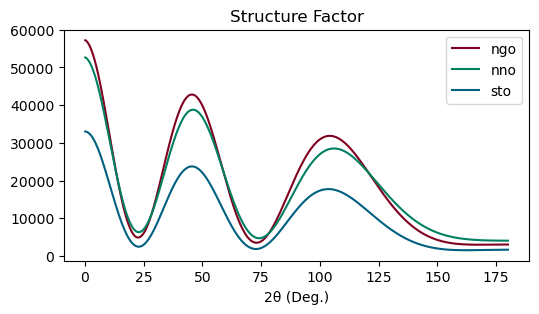

In [84]:
plt.figure(figsize=(6,3))
plt.title('Structure Factor')
plt.plot(TTHETA, sbs(ngo.SF(Q)), color='#800020', label='ngo')
plt.plot(TTHETA, sbs(nno.SF(Q)), color='#008060', label='nno')
plt.plot(TTHETA, sbs(sto.SF(Q)), color='#006080', label='sto')
plt.xlabel("2θ (Deg.)")
plt.legend()
plt.xlabel("2θ (Deg.)")
plt.legend()

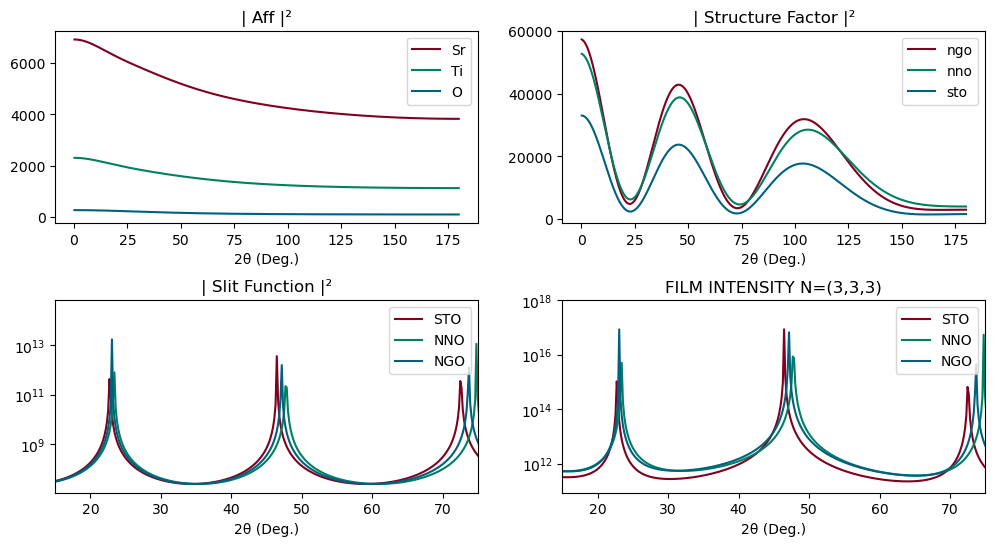

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# First subplot
axs[0, 0].set_title('| Aff |²')
axs[0, 0].plot(TTHETA, sbs(Sr.aff(Q)), color='#800020', label='Sr')
axs[0, 0].plot(TTHETA, sbs(Ti.aff(Q)), color='#008060', label='Ti')
axs[0, 0].plot(TTHETA, sbs(O.aff(Q)), color='#006080', label='O')
axs[0, 0].set_xlabel("2θ (Deg.)")
axs[0, 0].legend()

# Second subplot
axs[0, 1].set_title('| Structure Factor |²')
axs[0, 1].plot(TTHETA, sbs(ngo.SF(Q)), color='#800020', label='ngo')
axs[0, 1].plot(TTHETA, sbs(nno.SF(Q)), color='#008060', label='nno')
axs[0, 1].plot(TTHETA, sbs(sto.SF(Q)), color='#006080', label='sto')
axs[0, 1].set_xlabel("2θ (Deg.)")
axs[0, 1].legend()

# Third subplot
axs[1, 0].set_title('| Slit Function |²')
axs[1, 0].semilogy(TTHETA, sbs(STO_Bulk.SN(Q)), color='#800020', label="STO")
axs[1, 0].semilogy(TTHETA, sbs(NNO_Bulk.SN(Q)), color='#008060', label='NNO')
axs[1, 0].semilogy(TTHETA, sbs(NGO_Bulk.SN(Q)), color='#006080', label='NGO')
axs[1, 0].set_xlabel("2θ (Deg.)")
axs[1, 0].set_xlim([15, 75])
axs[1, 0].legend()

# Fourth subplot
axs[1, 1].set_title('FILM INTENSITY N=(3,3,3)')
axs[1, 1].semilogy(TTHETA, STO_Bulk.I(Q), color='#800020', label="STO")
axs[1, 1].semilogy(TTHETA, NNO_Bulk.I(Q), color='#008060', label='NNO')
axs[1, 1].semilogy(TTHETA, NGO_Bulk.I(Q), color='#006080', label='NGO')
axs[1, 1].set_xlabel("2θ (Deg.)")
axs[1, 1].set_xlim([15, 75])
axs[1, 1].legend()

# Adjust the space between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.show()


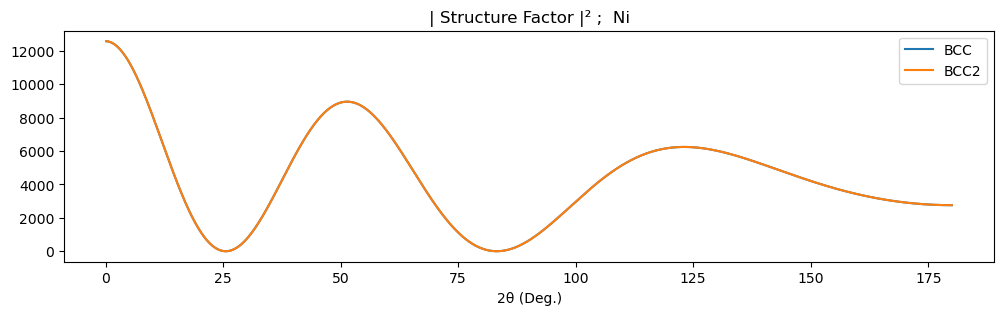

In [86]:
ni_sc = SC(
    abc = 3.48 * vec(1, 1, 1),
    X   = Ni
)
ni_fcc = FCC(
    abc = 3.48 * vec(1, 1, 1),
    X   = Ni
)
ni_bcc = BCC(
    abc = 3.48 * vec(1, 1, 1),
    AB   = (Ni, Ni)
)
ni_bcc2 = BCC(
    abc = 3.48 * vec(1, 1, 1),
    AB   = (Ni, Ni)
)
ni_pvs = Perovskite(
    abc = 3.48 * vec(1, 1, 1),
    ABO   = (Ni, Ni, Ni)
)
plt.figure(figsize=(12,3))
# plt.plot(TTHETA, sbs(ni_sc.SF(Q)), label='SC')
# plt.plot(TTHETA, sbs(ni_fcc.SF(Q)), label='FCC')
plt.plot(TTHETA, sbs(ni_bcc.SF(Q)), label='BCC')
plt.plot(TTHETA, sbs(ni_bcc2.SF(Q)), label='BCC2')
# plt.plot(TTHETA, sbs(ni_pvs.SF(Q)), label='PVS')
plt.title("| Structure Factor |² ;  Ni")
plt.xlabel('2θ (Deg.)')
plt.legend()

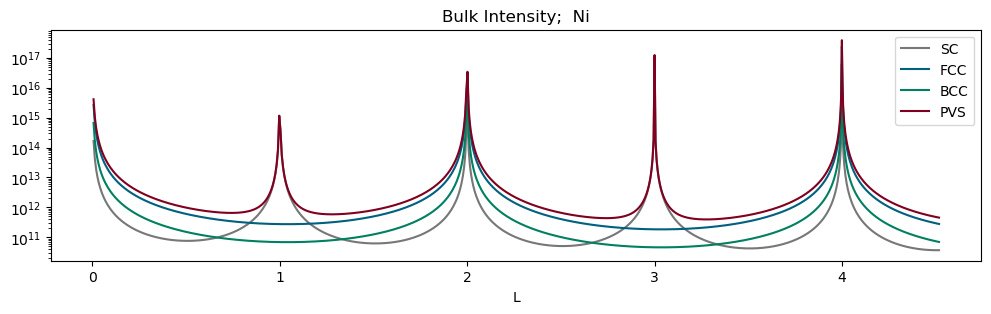

In [87]:
L_ni = ni_sc.Q2HKL(Q)[:, 2]
NI_SC = Film(ni_sc, (100, 100, inf))
NI_FCC = Film(ni_fcc, (100, 100, inf))
NI_BCC = Film(ni_bcc, (100, 100, inf))
NI_PVS = Film(ni_pvs, (100, 100, inf))

plt.figure(figsize=(12,3))
plt.semilogy(L_ni, NI_SC.I(Q), label='SC', color='#777777')
plt.semilogy(L_ni, NI_FCC.I(Q), label='FCC', color='#006080')
plt.semilogy(L_ni, NI_BCC.I(Q), label='BCC', color='#008060')
plt.semilogy(L_ni, NI_PVS.I(Q), label='PVS', color='#800020')
plt.title("Bulk Intensity;  Ni")
plt.xlabel('L')
plt.legend()

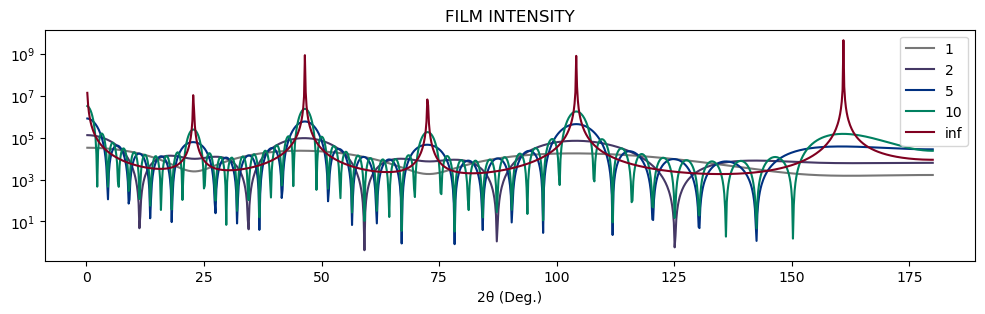

In [88]:
plt.figure(figsize=(12,3))
STO_gen = lambda Nc: Film(sto, (1,1,Nc))
plt.title('FILM INTENSITY')
plt.semilogy(TTHETA, STO_gen(1).I(Q), color='#777777', label="1")
plt.semilogy(TTHETA, STO_gen(2).I(Q), color='#453865', label="2")
plt.semilogy(TTHETA, STO_gen(5).I(Q), color='#003080', label="5")
plt.semilogy(TTHETA, STO_gen(10).I(Q), color='#008060', label="10")
plt.semilogy(TTHETA, STO_gen(inf).I(Q), color='#800020', label="inf")
plt.xlabel("2θ (Deg.)")
plt.legend()

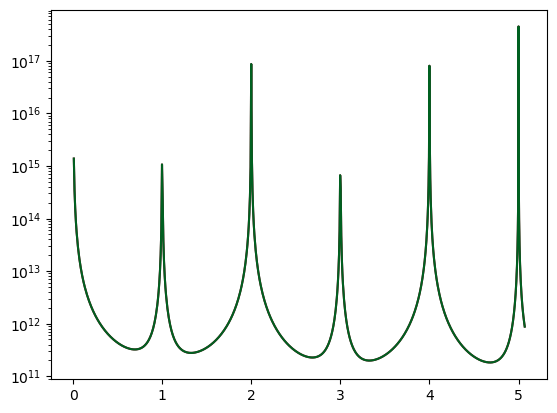

In [89]:
XRD = Xray()
Q = XRD.Q(0,0,1)
L = sto.Q2HKL(Q)[:, 2]
TTHETA = XRD.TTHETA



# plt.semilogy(L, Sample(NNO_Bulk, STO_Bulk).I(Q))
# plt.semilogy(L, Sample(NNO_Bulk, NGO_Bulk, STO_Bulk).I(Q))
plt.semilogy(L, NNOSTO.I(Q), color='#800020')
plt.semilogy(L, NGOSTO.I(Q), color='#006020')
# plt.ylim([1E10, 1E11])
# plt.xlim([2.5, 2.6])
# plt.semilogy(L, NGOSTO.I(Q))
# plt.semilogy(L, NNONGOSTO.I(Q))